In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# image augmentation
import imgaug

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.__version__

'2.0.1+cu118'

#### Download data

In [2]:
# download dataset
!pip install --upgrade gdown
!gdown --id 1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H --output brain-mri-seg.zip
# unzip file
!unzip -q brain-mri-seg.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H
From (redirected): https://drive.google.com/uc?id=1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H&confirm=t&uuid=28a76151-c478-4070-a594-319f84876135
To: /content/brain-mri-seg.zip
100% 130M/130M [00:01<00:00, 73.1MB/s]


#### Data Analysis


---

brain-mri-seg


*   train/
    *   pat_1.tif
    *   pat_1**_mask**.tif
    *   pat_2.tif
    *   pat_2**_mask**.tif
    *   ...
*   test/
    *   ...

Image shape: (H, W, C)

*   C: 3 MRI channels(modalities)

Mask  shape: (H, W, C)

*   C: 3, all channels with same values
    * 0: background
    * 255: tumor

In [7]:
# random pick 1 image and mask
mask_paths = glob('brain-mri-seg/train/*_mask.tif') # read all mask files
img_paths = [p.replace("_mask", '') for p in mask_paths] # convert path from mask to image

idx = np.random.randint(0, len(mask_paths)) # sample 1 idx
mask_path = mask_paths[idx]
img_path = img_paths[idx]
# read image and mask
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

print('img_path: ', img_path, '\nmask path:',  mask_path)
print(f'img.shape : {img.shape},\nmask.shape: {mask.shape}')

img_path:  brain-mri-seg/train/TCGA_DU_7018_19911220_15.tif 
mask path: brain-mri-seg/train/TCGA_DU_7018_19911220_15_mask.tif
img.shape : (256, 256, 3),
mask.shape: (256, 256, 3)


In [8]:
len(img_paths), len(mask_paths)

(1098, 1098)

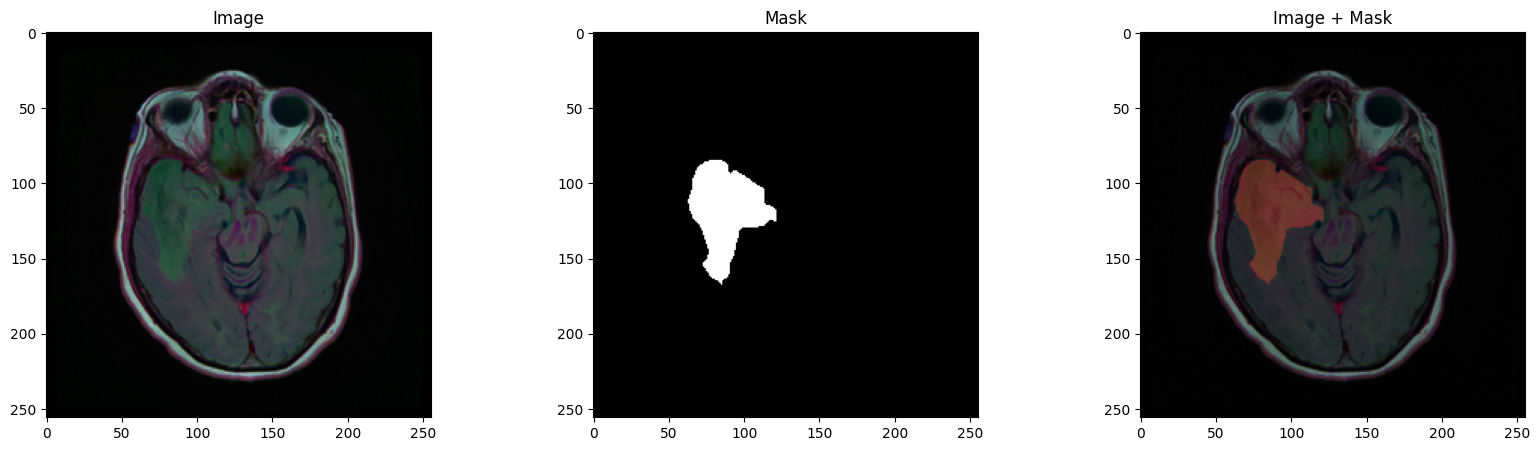

In [9]:
# show image & mask
def plot_img_mask(img, mask):
    plt.figure(figsize=(20, 5))
    plt.subplot(1,3,1)
    plt.title('Image')
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.title('Mask')
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('Image + Mask')
    plt.imshow(img)
    plt.imshow(mask * np.array([1, 0, 0]), alpha=0.3) # convert mask to red color
    plt.show()

plot_img_mask(img, mask)

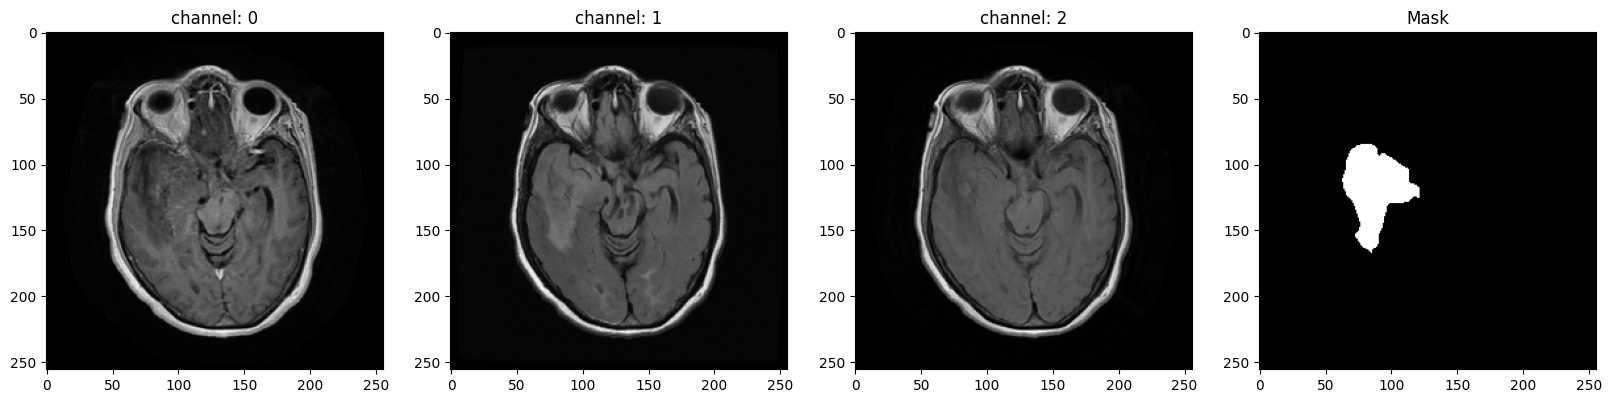

In [10]:
# show channelwise image
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.title(f'channel: {i}')
    plt.imshow(img[:, :, i], cmap='gray')
plt.subplot(1, 4, 4)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [11]:
# Calculate tumor pixel
values, counts = np.unique(mask, return_counts=True)
values, counts

(array([  0, 255], dtype=uint8), array([188958,   7650]))

# Dataset & Dataloader



*   Image
    * shape: (H, W, 3) -> (3, H, W)
    * value: 0 ~ 255  ->  0. ~ 1. **float**
*   Mask
    * shape: (H, W, 3) -> (H, W)
    * value: 0 or 255  -> 0 or 1 **int**
*   Augmentation
    * imgaug: https://imgaug.readthedocs.io/en/latest/source/examples_segmentation_maps.html



In [12]:
IMG_SIZE = 256 # 16X, 32X
BS = 16

In [13]:
class TumorDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, img_size, augmentation=False):
        # Read all mask paths
        self.mask_paths = glob(os.path.join(folder_path, '*_mask.tif'))
        # mask paths -> img paths
        self.img_paths = [m_path.replace('_mask', '') for m_path in self.mask_paths]
        self.img_size = img_size
        # Data Augmentation
        self.augmentation = augmentation
        self.augmentor = imgaug.augmenters.Sequential([
            imgaug.augmenters.Fliplr(0.5), # 50% horizontal flip
            imgaug.augmenters.Affine(
                rotate=(-45, 45), # random rotate -45 ~ +45 degree
                shear=(-16, 16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        # get img & mask path
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]
        # Read img & mask
        img = cv2.imread(img_path) # (H, W, 3)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path) # (H, W, 3)
        # Resize
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        # convert mask to 1 channel (H, W, 3) -> (H, W, 1)
        mask = mask[:, :, :1]
        # Normalize Image
        img = img / 255. # 0~255 -> 0~1
        # Binarize mask from [0, 255] to (0 or 1)
        mask = np.where(mask<127, 0, 1).astype(np.int16)

        # Augment mask by imgaug
        if self.augmentation:
            # to imgaug data class
            mask = imgaug.augmentables.segmaps.SegmentationMapsOnImage(mask,
                                                                       shape=mask.shape)
            # augment img & mask "simultaneously"
            img, mask = self.augmentor(image=img, segmentation_maps=mask)
            mask = mask.get_arr() # to np.ndarray

        # 1. Convert to PyTorch Tensor
        # 2. Channel last to first: (H, W, C) -> (C, H, W)
        # Tensor datatype:
        # Img: float, Mask: long
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long).squeeze(-1) # (H, W, 1) -> (H, W)
        return img, mask

In [14]:
train_ds = TumorDataset('brain-mri-seg/train',
                        IMG_SIZE,
                        augmentation=True)
val_ds = TumorDataset('brain-mri-seg/test',
                      IMG_SIZE)

# https://pytorch.org/docs/stable/data.html
# >0: accelerate loading data by muli-process
NUM_WORKERS = 2

train_loader = torch.utils.data.DataLoader(train_ds,
                                           BS,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_ds,
                                         BS,
                                         num_workers=NUM_WORKERS)

Visulize data

img.shape:  torch.Size([3, 256, 256]) 
mask.shape:  torch.Size([256, 256])
mask values:  [0 1]


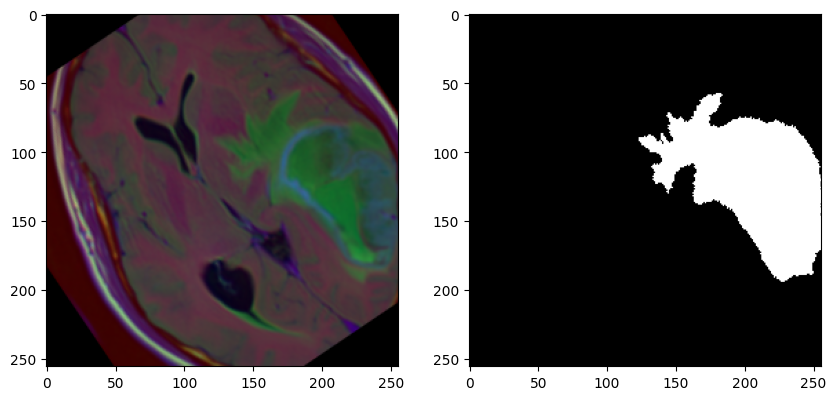

In [17]:
img, mask = train_ds[0] # take 1 data

print('img.shape: ', img.shape, '\nmask.shape: ', mask.shape)
print('mask values: ', np.unique(mask))
img = img.numpy().transpose(1, 2, 0) # (C, H, W) -> (H, W, C)
mask = mask.numpy().squeeze() # (1, H, W) -> (H, W)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

#### Build model: simple UNet

In [35]:
# Basic Conv block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, init_features=32):
        super().__init__()
        # Encoder
        self.encoder1 = ConvBlock(in_channels, init_features) # (3, H, W) -> (32, H, W)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(init_features, init_features*2) # (32, H/2, W/2) -> (64, H/2, W/2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(init_features*2, init_features*4) # (64, H/4, W/4) -> (128, H/4, W/4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(init_features*4, init_features*8) # (128, H/8, W/8) -> (256, H/8, W/8)
        self.pool4 = nn.MaxPool2d(2)
        self.encoder5 = ConvBlock(init_features*8, init_features*16) # (256, H/16, W/16) -> (512, H/16, W/16)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(init_features*16, # (512, H/16, W/16) -> (256, H/8, W/8)
                          init_features*8,
                          kernel_size=2, stride=2)
        self.decoder4 = ConvBlock(init_features*8*2, init_features*8)
        self.upconv3 = nn.ConvTranspose2d(init_features*8, # (256, H/8, W/8) -> (128, H/4, W/4)
                          init_features*4,
                          kernel_size=2, stride=2)
        self.decoder3 = ConvBlock(init_features*4*2, init_features*4)
        self.upconv2 = nn.ConvTranspose2d(init_features*4, # (128, H/4, W/4) -> (64, H/2, W/2)
                          init_features*2,
                          kernel_size=2, stride=2)
        self.decoder2 = ConvBlock(init_features*2*2, init_features*2)
        self.upconv1 = nn.ConvTranspose2d(init_features*2, # (62, H/2, W/2) -> (32, H, W)
                          init_features,
                          kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(init_features*2, init_features)

        # Output (head): classification for each pixel, C=2
        self.output = nn.Conv2d(
            init_features,
            out_channels=out_channels,
            kernel_size=1) # (32, H, W) -> (2, H, W)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.encoder5(self.pool4(enc4))

        # Decoder
        # (BS, 256, H/8, W/8) + (BS, 256, H/8, W/8) -> (BS, 512, H/8, W/8)
        x = torch.cat((self.upconv4(bottleneck), enc4), dim=1)
        x = self.decoder4(x)

        x = torch.cat((self.upconv3(x), enc3), dim=1)
        x = self.decoder3(x)

        x = torch.cat((self.upconv2(x), enc2), dim=1)
        x = self.decoder2(x)

        x = torch.cat((self.upconv1(x), enc1), dim=1)
        x = self.decoder1(x)

        x = self.output(x)
        return x

In [29]:
inputs = torch.randn(1, 3, 256, 256)
model = UNet(in_channels=3,
             out_channels=2,
             init_features=16)
outputs = model(inputs)
outputs.shape

torch.Size([1, 256, 32, 32])
torch.Size([1, 128, 32, 32])


torch.Size([1, 2, 256, 256])

#### Training

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# build model to GPU
model = UNet(in_channels=3,
             out_channels=2,
             init_features=16).to(device)

cuda


In [37]:
model.output

Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))

#### Dice coefficient

Dice coefficient, or Dice-Sørensen coefficient

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

#### Loss function for segmentation

1.   Cross Entropy
2.   Dice Loss = 1 - Dice coefficient
3.   IoU Loss

ref: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch/notebook


In [38]:
# PyTorch Dice loss
!pip install fusionlab

import fusionlab as fl
from fusionlab.losses import DiceLoss, IoULoss

class DiceScore(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice_loss = DiceLoss()
    def forward(self, pred, true):
        loss = self.dice_loss(pred, true)
        return 1-loss

dice_score = DiceScore()

In [39]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_dice = 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        epoch_dice += dice_score(pred, y).item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_dice/num_batches


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_dice = 0
    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_dice += dice_score(pred, y).item()

    return epoch_loss/num_batches, epoch_dice/num_batches

In [40]:
EPOCHS = 50
logs = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': [],
}
# loss_fn = nn.CrossEntropyLoss() # classification for each pixel
loss_fn = fl.losses.DiceLoss("multiclass") # IoULoss

optimizer = torch.optim.Adam(model.parameters())

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_dice = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_dice = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_dice'].append(train_dice)
    logs['val_dice'].append(val_dice)

    print(f'EPOCH: {epoch:04d} train_loss: {train_loss:.4f} val_loss: {val_loss:.4f}, train_dice: {train_dice:.3f}, val_dice: {val_dice:.3f}')

    # On epoch end
    torch.save(model.state_dict(), "last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0000 train_loss: 0.5224 val_loss: 0.5406, train_dice: 0.478, val_dice: 0.459


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0001 train_loss: 0.4032 val_loss: 0.3168, train_dice: 0.597, val_dice: 0.683


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0002 train_loss: 0.2834 val_loss: 0.2746, train_dice: 0.717, val_dice: 0.725


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0003 train_loss: 0.1955 val_loss: 0.2460, train_dice: 0.805, val_dice: 0.754


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0004 train_loss: 0.1554 val_loss: 0.1614, train_dice: 0.845, val_dice: 0.839


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0005 train_loss: 0.1429 val_loss: 0.2052, train_dice: 0.857, val_dice: 0.795


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0006 train_loss: 0.1365 val_loss: 0.1514, train_dice: 0.863, val_dice: 0.849


  0%|          | 0/69 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bad14f9f5b0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bad14f9f5b0>    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

EPOCH: 0007 train_loss: 0.1292 val_loss: 0.1251, train_dice: 0.871, val_dice: 0.875


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0008 train_loss: 0.1208 val_loss: 0.1197, train_dice: 0.879, val_dice: 0.880


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0009 train_loss: 0.1148 val_loss: 0.1258, train_dice: 0.885, val_dice: 0.874


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0010 train_loss: 0.1158 val_loss: 0.1526, train_dice: 0.884, val_dice: 0.847


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0011 train_loss: 0.1122 val_loss: 0.1148, train_dice: 0.888, val_dice: 0.885


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0012 train_loss: 0.1055 val_loss: 0.1215, train_dice: 0.895, val_dice: 0.878


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0013 train_loss: 0.1051 val_loss: 0.1173, train_dice: 0.895, val_dice: 0.883


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0014 train_loss: 0.1013 val_loss: 0.1141, train_dice: 0.899, val_dice: 0.886


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0015 train_loss: 0.1040 val_loss: 0.1228, train_dice: 0.896, val_dice: 0.877


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0016 train_loss: 0.1012 val_loss: 0.1196, train_dice: 0.899, val_dice: 0.880


  0%|          | 0/69 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bad14f9f5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bad14f9f5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

EPOCH: 0017 train_loss: 0.0980 val_loss: 0.0985, train_dice: 0.902, val_dice: 0.901


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0018 train_loss: 0.1029 val_loss: 0.1014, train_dice: 0.897, val_dice: 0.899


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0019 train_loss: 0.0945 val_loss: 0.1071, train_dice: 0.906, val_dice: 0.893


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0020 train_loss: 0.1008 val_loss: 0.1156, train_dice: 0.899, val_dice: 0.884


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0021 train_loss: 0.0943 val_loss: 0.1088, train_dice: 0.906, val_dice: 0.891


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0022 train_loss: 0.0928 val_loss: 0.1044, train_dice: 0.907, val_dice: 0.896
Earlystop!


#### Logs

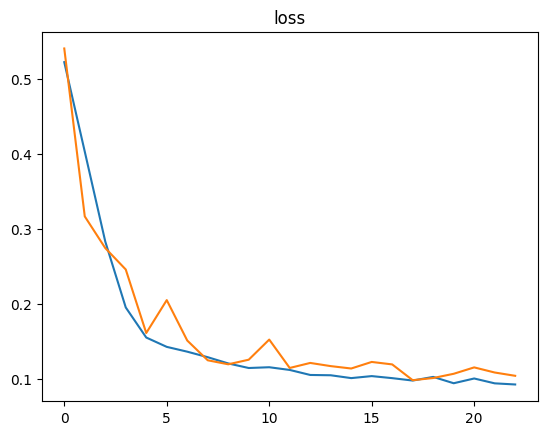

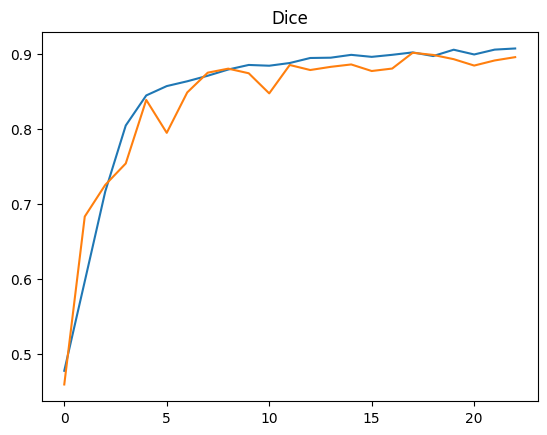

In [41]:
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.title('loss')
plt.show()
plt.plot(logs['train_dice'])
plt.plot(logs['val_dice'])
plt.title('Dice')
plt.show()

#### Eval

In [42]:
model.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

37


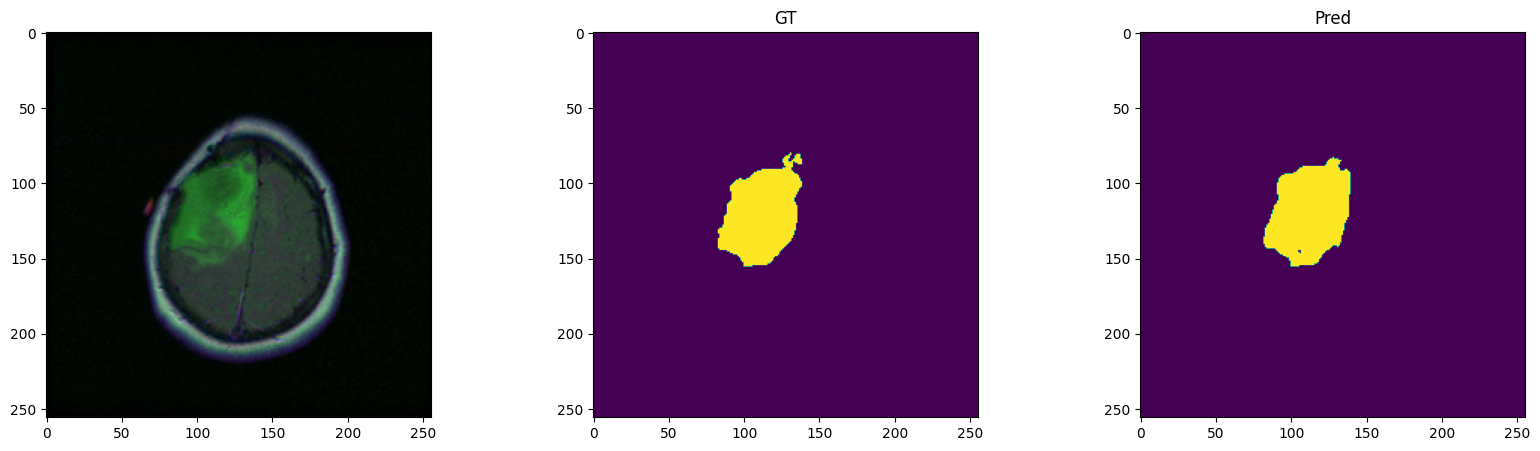

In [49]:
# Sample data
idx = np.random.randint(len(val_ds))
print(idx)
img, mask = val_ds[idx] # (3, H, W) (H, W)
mask_pred = model(img.unsqueeze(0).to(device))

# show inputs img, GT, model prediction
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('GT')
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.title("Pred")
plt.imshow(mask_pred[0].cpu().argmax(0))
plt.show()

#### Color Mask

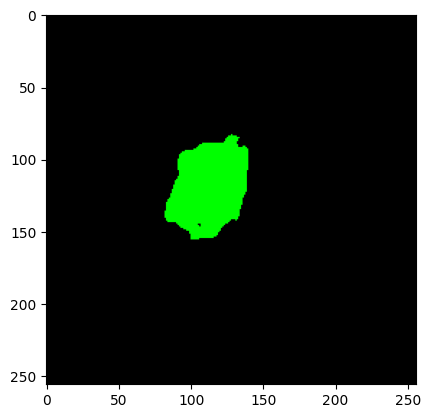

In [50]:
colors = [
    [0, 0, 0],  # black for background
    [0, 255, 0]
]
mask_pred = mask_pred[0].cpu().argmax(0).numpy()
# class idx to color
mask_colors = np.array([colors[int(pixel)] for pixel in mask_pred.reshape(-1)]).reshape(IMG_SIZE, IMG_SIZE, 3)

plt.imshow(mask_colors)

### Exercise

1. U-Net architecture (stages, depths ...)
2. Batch Normalization
3. More Image Augmentation
4. Dice Loss, IoU Loss
5. Another Dataset

#### More models



*   https://github.com/qubvel/segmentation_models.pytorch
*   https://github.com/taipingeric/fusionlab



In [ ]:
m = fl.segmentation.ResUNet(cin=3, num_cls=2, base_dim=16)
m = fl.segmentation.UNet(cin=3, num_cls=2, base_dim=16)
m = fl.segmentation.UNet2plus(cin=3, num_cls=2, base_dim=16)

loss_fn = fl.losses.DiceLoss("multiclass")
loss_fn = fl.losses.IoULoss("multiclass")